<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [20]</a>'.</span>

### Utility

In [2]:
from ase.cluster import Decahedron, Icosahedron, Octahedron, wulff_construction
from ase import Atoms 
from ase.io import Trajectory
import pandas as pd
from ase.build import bulk
from ase.constraints import ExpCellFilter, StrainFilter
from ase.optimize import LBFGS
import numpy as np

import pfp_api_client
from pfp_api_client.pfp.calculators.ase_calculator import ASECalculator
from pfp_api_client.pfp.estimator import Estimator, EstimatorCalcMode, EstimatorMethodType
from ase.io import Trajectory, write
from ase.build import bulk, surface, molecule, add_adsorbate, fcc111
from ase.constraints import ExpCellFilter, StrainFilter, FixAtoms, FixedPlane, FixBondLength
from ase.vibrations import Vibrations
from ase.thermochemistry import IdealGasThermo
from ase.visualize import view
from ase.build.rotate import minimize_rotation_and_translation
from ase.io.vasp import read_vasp, write_vasp
from ase.io import read
import pandas as pd
import ipywidgets as widgets
from IPython.display import display_png, Image as ImageWidget
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import shutil
import glob
from pathlib import Path
from PIL import Image, ImageDraw
from pymatgen.core import Lattice, Structure, Molecule
from pymatgen.core.surface import SlabGenerator
from pymatgen.io.ase import AseAtomsAdaptor
import numpy as np
from scipy.spatial.distance import cdist

def visual2(structure,title,  max_size=(100, 100), rotation='15z,-90x',celloff=True):
    def calculate_stretch_factor(cell):
        """Calculate the stretch factor for visualization based on the cell dimensions."""
        x_length = cell[0][0]
        y_length = cell[1][1]

        # Avoid division by zero
        if y_length == 0:
            return 1.0

        stretch_y = y_length / x_length
        return stretch_y

    # Calculate stretch factor based on the structure's cell
    stretch_y = calculate_stretch_factor(structure.cell)
    temp=structure.copy()
    if celloff==True:
      temp.cell = None
    # Visualize the structure
    renderer = write('./temp.pov', temp, rotation=rotation)
    renderer.render()
    image_path = f'./temp.png'
    img = Image.open(image_path)

    # Calculate new size with stretch factor
    new_size = (max_size[0], int(max_size[1] * stretch_y))
    img = img.resize(new_size, Image.LANCZOS)
    img.info['dpi'] = 2000
    display(img)

    # Move files to output directory
    destination = './output/'
    files = ['./temp.ini', './temp.pov', './temp.png']

    # Ensure destination directory exists
    os.makedirs(destination, exist_ok=True)

    for file in files:
        # Remove the file in the destination directory if it exists
        if os.path.isfile(os.path.join(destination, os.path.basename(file))):
            os.remove(os.path.join(destination, os.path.basename(file)))

        shutil.move(file, destination)
    original_image_path = os.path.join(destination, 'temp.png')
    new_image_path = os.path.join(destination, f'{title}.png')

    # Rename the image file
    os.rename(original_image_path, new_image_path)
    
#############################Calculator setting###################################
calc_mode="CRYSTAL" # including +U correction
model_version="v4.0.0"  # the latest model version
method_type=EstimatorMethodType.PFVM
estimator = Estimator(calc_mode=calc_mode, model_version=model_version, method_type=method_type)
calculator = ASECalculator(estimator)
##################################################################################

def get_opt_energy(atoms, fmax=0.05, opt_mode: str = "normal"):    
    atoms.set_calculator(calculator)
    if opt_mode == "scale":
        opt1 = LBFGS(StrainFilter(atoms, mask=[1, 1, 1, 0, 0, 0]))
    elif opt_mode == "all":
        opt1 = LBFGS(ExpCellFilter(atoms))
    else:
        opt1 = LBFGS(atoms)
    opt1.run(fmax=fmax)
    return atoms.get_total_energy()

/home/jovyan/.py38/lib/python3.8/site-packages/pfp_api_client/__init__.py:35: UserWarning: New version of pfp-api-client is available. Please consider upgrading by `pip install -U pfp-api-client`.
  warnings.warn(


the customization is not there yet.

In [3]:
import pfp_api_client
from pfp_api_client.pfp.calculators.ase_calculator import ASECalculator
from ase.md.langevin import Langevin
from ase.md import MDLogger
from ase import units
from time import perf_counter
from copy import deepcopy
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution,Stationary
from ase.md.nvtberendsen import NVTBerendsen
from ase import units

def run_md_simulation_nvt(atoms, temperature, num_md_steps, num_interval, friction_coeff, traj_filename, log_filename,time_step):

    MaxwellBoltzmannDistribution(atoms, temperature_K=temperature,force_temp=True)
    Stationary(atoms)  # Set zero total momentum to avoid driftingW

    # run MD
    dyn = NVTBerendsen(atoms, time_step*units.fs, temperature_K = temperature, taut=taut*units.fs, loginterval=num_interval, trajectory=traj_filename)

    # Print statements
    def print_dyn():
        imd = dyn.get_number_of_steps()
        etot  = atoms.get_total_energy()
        temp_K = atoms.get_temperature()
        elapsed_time = perf_counter() - start_time
        print(f"  {imd: >3}   {etot:.3f}    {temp_K:.2f}    {elapsed_time:.3f}")


    dyn.attach(print_dyn, interval=num_interval)
    dyn.attach(MDLogger(dyn, atoms,log_filename, header=True, peratom=True, mode="a"), interval=num_interval)

    # Now run the dynamics
    start_time = perf_counter()
    print(f"    imd     Etot(eV)    T(K)    elapsed_time(sec)")
    dyn.run(num_md_steps)
    simulation_time = perf_counter() - start_time
    print(f"Total simulation time: {simulation_time:.3f} seconds")

In [4]:
from ase.build import fcc111, molecule, add_adsorbate
ceo2 = read_vasp("../../ceo2_bulk")
ceo2.calc = calculator
mol = molecule("O2")
mol.calc = calculator
E_mol = get_opt_energy(mol)
E_bulk = get_opt_energy(ceo2)
print(E_bulk,len(ceo2))

       Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
LBFGS:    0 12:54:24       -5.920261*       0.7392
LBFGS:    1 12:54:24       -5.920360*       0.7693
LBFGS:    2 12:54:24       -5.924292*       0.0295
       Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
LBFGS:    0 12:54:24      -83.902071*       0.0008
-83.90207072025697 12


N termination: 1
how many fixed atoms: 840 out of 1680


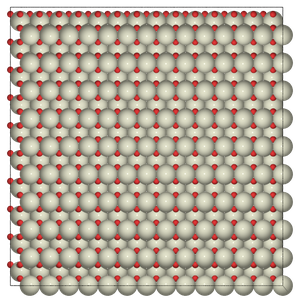

length and width : 55.154 A x 55.713 x 5.909  A
N_atoms: 1680
Composition: Ce: 560, O: 1120


In [4]:
from pymatgen.core.surface import SlabGenerator
from pymatgen.io.ase import AseAtomsAdaptor
from ase.build import make_supercell
import numpy as np
from collections import Counter
from scipy.spatial import distance

def fix_atoms(atoms):
    temp=atoms.copy()
    ce_positions = np.array([temp.position for temp in temp if temp.symbol == 'Ce'])
    ce_median_z = np.median(ce_positions[:, 2])
    mask = temp.positions[:, 2] < ce_median_z
    c = FixAtoms(mask=mask)
    temp.set_constraint(c)
    num_constrained_atoms = np.sum(mask)
    print("how many fixed atoms:", num_constrained_atoms, "out of", temp.get_global_number_of_atoms())
    
    return temp
def print_slab_info(atoms):
    # Calculate and print the size
    size_x = round(atoms.cell[0, 0], 3)
    size_y = round(atoms.cell[1, 1], 3)
    ce_positions = np.array([atom.position for atom in atoms if atom.symbol == 'Ce'])
    ce_min_z, ce_max_z = np.min(ce_positions[:, 2]), np.max(ce_positions[:, 2])
    size_z = round(ce_max_z-ce_min_z,3)
    print(f"length and width : {size_x} A x {size_y} x {size_z}  A")
    print(f"N_atoms: {len(atoms)}")
    symbols = atoms.get_chemical_symbols()
    element_counts = Counter(symbols)
    element_counts_line = ', '.join(f"{element}: {count}" for element, count in element_counts.items())
    print(f"Composition: {element_counts_line}")
    print("===============================")

def generate_slab(bulk, miller_index, supercell_dimensions,thick,fixoff=False):
    bulk_temp=bulk.copy()
    slab_gen = SlabGenerator(
        initial_structure=AseAtomsAdaptor.get_structure(bulk_temp),
        miller_index=miller_index,
        min_slab_size=thick,
        min_vacuum_size=40.0,
        lll_reduce=False,
        center_slab=True,
        primitive=True,
        max_normal_search=1,
    )
    
    slabs = slab_gen.get_slabs(tol=0.3, bonds=None, max_broken_bonds=0, symmetrize=False)
    slab_atoms_list = [AseAtomsAdaptor.get_atoms(slab) for slab in slabs]
    print('N termination:',len(slab_atoms_list))
    slab = slab_atoms_list[0].copy()
    slab = slab * supercell_dimensions
    
    # Shift `slab` to the bottom of the cell
    min_pos_z = np.min(slab.positions, axis=0)[2]
    slab.set_positions(slab.positions - [0, 0, min_pos_z])
    temp = slab.copy()
    if fixoff==False:
        temp = fix_atoms(temp)
        
    return temp

# Example usage:
m_110 = [1, 1, 0]
rod_size = (14, 10, 1)

rod_slab = generate_slab(ceo2, m_110, rod_size,6)
visual2(rod_slab,'rod_surf',(300, 300),'0z,-0x',celloff=False)
print_slab_info(rod_slab)

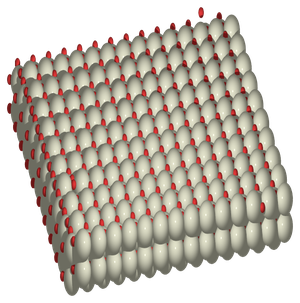

In [8]:
rod_relaxed=read_vasp('./rod_relaxed.vasp')
visual2(rod_relaxed, f'test', (300, 300), rotation='15z,-65x', celloff=True)

In [9]:
'''for strs in rand_cubes_stoi:
    visual2(strs, f'test', (100, 100), rotation='15z,-75x', celloff=True)
'''

"for strs in rand_cubes_stoi:\n    visual2(strs, f'test', (100, 100), rotation='15z,-75x', celloff=True)\n"

In [9]:
atoms = rod_slab
atoms.calc = calculator
time_step    = 1   # fsec
temperature = 400+273
num_md_steps = 1E+3
num_interval = 5E+1
friction_coeff = 0.002
taut         = 1.0    # fs
traj_filename = f"./output/1_rod.traj"
log_filename = f"./output/1_rod.log"
run_md_simulation_nvt(atoms, temperature, num_md_steps, num_interval, friction_coeff, traj_filename, log_filename,time_step)

    imd     Etot(eV)    T(K)    elapsed_time(sec)
    0   -10931.811    2692.00    0.126
   50   -11142.053    678.45    17.000
  100   -11146.231    675.20    34.188
  150   -11159.375    671.44    55.717
  200   -11157.262    670.23    73.097
  250   -11136.195    669.10    95.842
  300   -11140.603    671.45    113.142
  350   -11148.286    674.39    135.980
  400   -11154.024    673.38    152.706
  450   -11154.931    673.97    169.790
  500   -11148.153    672.98    192.087
  550   -11143.044    674.11    209.297
  600   -11147.591    675.90    231.480
  650   -11153.099    675.14    255.296
  700   -11155.999    670.31    273.216
  750   -11152.051    674.42    295.745
  800   -11151.764    671.79    318.913
  850   -11152.527    672.47    340.613
  900   -11150.894    673.61    368.204
  950   -11154.872    675.53    391.328
  1000   -11156.146    673.45    429.331
Total simulation time: 429.332 seconds


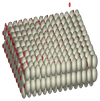

In [10]:
visual2(rod_slab, f'test', (100, 100), rotation='15z,-75x', celloff=True)

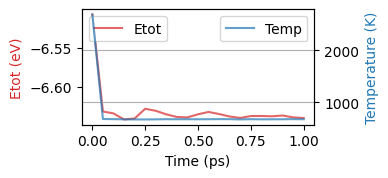

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def parse_log_file(filename):
    with open(filename, "r") as file:
        lines = file.readlines()

    run_data = []
    for line in lines:
        if "Time[ps]" not in line:
            try:
                tokens = line.split()
                time, etot, temp = float(tokens[0]), float(tokens[1]), float(tokens[4])
                run_data.append((time, etot, temp))
            except (ValueError, IndexError):
                pass

    return run_data

def plot_log_data(log_data):
    fig, ax1 = plt.subplots(figsize=(3, 1.5))
    time = [row[0] for row in log_data]
    etot = [row[1] for row in log_data]
    temp = [row[2] for row in log_data]
    ax1.plot(time, etot, color='tab:red', label='Etot', alpha=0.7)
    ax2 = ax1.twinx()
    ax2.plot(time, temp, color='tab:blue', label='Temp', alpha=0.7)
    ax1.set_xlabel('Time (ps)')
    ax1.set_ylabel('Etot (eV)', color='tab:red')
    ax2.set_ylabel('Temperature (K)', color='tab:blue')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.grid(True)
    plt.show()


log_filename = f"./output/1_rod.log"
log = parse_log_file(log_filename)
plot_log_data(log)


In [12]:
get_opt_energy(rod_slab,0.05)

       Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
LBFGS:    0 01:18:10   -11229.267870*       3.3391
LBFGS:    1 01:18:15   -11245.478587*       2.2657
LBFGS:    2 01:18:15   -11273.806783*       1.8285
LBFGS:    3 01:18:15   -11278.794909*       1.5875
LBFGS:    4 01:18:15   -11287.378074*       1.3528
LBFGS:    5 01:18:16   -11291.211665*       1.1496
LBFGS:    6 01:18:16   -11294.384512*       1.0658
LBFGS:    7 01:18:16   -11296.789334*       0.9045
LBFGS:    8 01:18:16   -11299.796494*       1.0953
LBFGS:    9 01:18:16   -11302.250250*       1.5267
LBFGS:   10 01:18:21   -11304.132252*       0.7628
LBFGS:   11 01:18:22   -11305.482702*       0.6968
LBFGS:   12 01:18:22   -11306.725222*       0.7317
LBFGS:   13 01:18:22   -11307.673277*       0.8549
LBFGS:   14 01:18:22   -11308.344278*       0.5707
LBFGS:   15 01:18:22   -11308.825032*       0.5357
LBFGS:   16 01:18:22   -11309.194890*       0.5672
LBFGS:   17 01:18:23   -11309.4930

-11238.563137752368

In [13]:
write('./rod_relaxed.vasp',rod_slab)